# Duke ML Project - Sparse Array DL
## Title: Data Preprocessing Notebook
## Author: Anthony DiSpirito III
## Github: @axd465

### Import Statements

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import shutil
import imageio
import scipy
from functools import partial

GPU = 0
GPU_MEM = None#40960 # in Mb
use_mixed_prec = False

physical_gpus = tf.config.list_physical_devices('GPU')

if physical_gpus:
    try:
        # Disable GPU
        if GPU is None:
            gpu_id = []
        else:
            gpu_id = physical_gpus[GPU:GPU+1]
        tf.config.set_visible_devices(gpu_id, 'GPU')
        visible_gpus = tf.config.get_visible_devices('GPU')
        tf.config.experimental.set_memory_growth(*visible_gpus, True)
        print("Num Visible Physical GPUs: ", len(physical_gpus),
              "\nNum Visible GPUs Available: ", len(visible_gpus))
        if GPU is not None and GPU_MEM is not None:
            tf.config.set_logical_device_configuration(
                gpu_id[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=GPU_MEM)]
            )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(visible_gpus), "Visible GPUs,", len(logical_gpus), "Logical GPUs")
        print(f"Visible Devices are: {tf.config.get_visible_devices()}")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

%matplotlib inline
%load_ext autoreload
%autoreload 2
print('Tensorflow version: ' + tf.__version__)

# For Mixed Precision
from tensorflow.keras import mixed_precision
if use_mixed_prec:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)

Num Visible Physical GPUs:  1 
Num Visible GPUs Available:  1
1 Visible GPUs, 1 Logical GPUs
Visible Devices are: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version: 2.11.0


In [2]:
from python.utils.vol_process_utils import import_mat

sparse_mat_dict = import_mat("./recon_code/pa_code/sparse_matrix.mat")
rfdata_dict = import_mat("./recon_code/pa_code/test_rfdata.mat")

In [3]:
sparse_mat_dict.keys()

dict_keys(['Cols', 'Rows', 'arr_size', 'data', 'interp_scale', 'mat_file_version'])

In [4]:
rfdata_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'interp_scale', 'rfdata', 'mat_file_version'])

In [5]:
rfdata = np.array(rfdata_dict["rfdata"], dtype=np.float32)
new_size = [rfdata.shape[0]*sparse_mat_dict["interp_scale"][0, 0],
            rfdata.shape[1]*sparse_mat_dict["interp_scale"][1, 0]]
new_size = np.array(new_size, dtype=np.int32)
print(new_size)
rfdata = np.squeeze(tf.image.resize(rfdata[..., tf.newaxis], size=new_size))

[7680  256]


In [6]:
rfdata.shape

(7680, 256)

In [8]:
indices = np.zeros([sparse_mat_dict["Cols"].shape[-1], 2], dtype=np.int64)
indices[:, 1] = np.array(sparse_mat_dict["Cols"], dtype=np.int64) - 1
indices[:, 0] = np.array(sparse_mat_dict["Rows"], dtype=np.int64) - 1
values = np.array(sparse_mat_dict["data"], dtype=np.float32).flatten()
dense_shape = np.array(sparse_mat_dict["arr_size"]).flatten()

In [9]:
dense_shape

array([2496688., 1966080.])

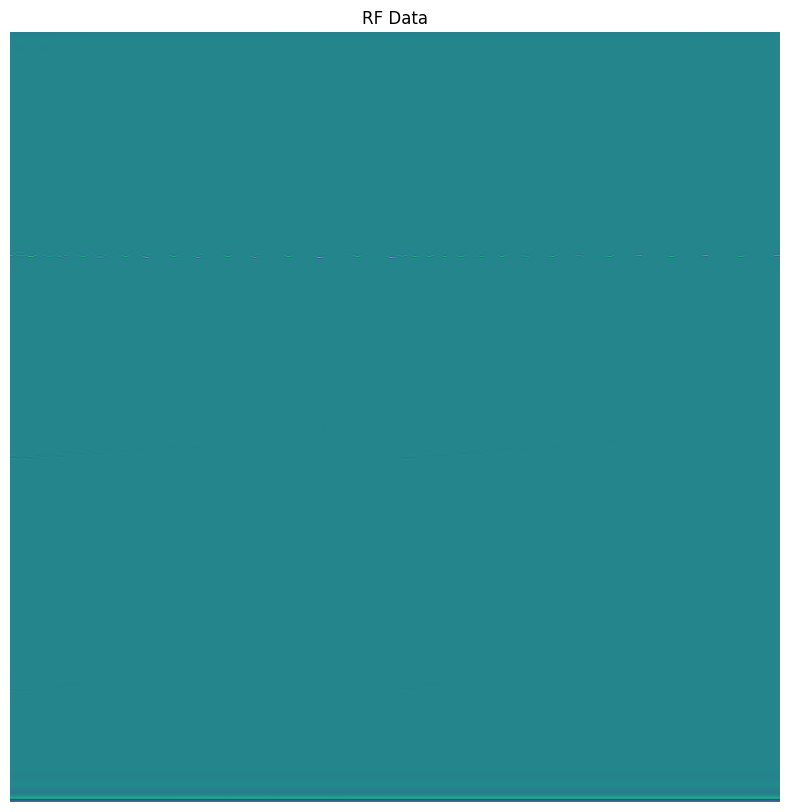

In [10]:
norm_rfdata = (rfdata - np.min(rfdata))/(np.max(rfdata) - np.min(rfdata))
plt.figure(figsize=(10, 10))
plt.imshow(rfdata, extent=[0, 1, 0, 1])
plt.axis('off')
plt.title("RF Data")
plt.show()

In [11]:
rfdata_flat = rfdata.T.flatten()[..., tf.newaxis]
print(rfdata_flat.shape)

(1966080, 1)


In [12]:
M = tf.sparse.SparseTensor(indices, values, dense_shape)

In [18]:
@tf.function
def tf_gpu_matmul(M, x):
    return tf.sparse.sparse_dense_matmul(M, x)

In [24]:
%timeit out = tf_gpu_matmul(M, rfdata_flat)

31.1 ms ± 34 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
out = tf_gpu_matmul(M, rfdata_flat)
# p0_recon = tf.reshape(out, (136, 137, 134))
p0_recon = tf.reshape(out, (134, 137, 136))

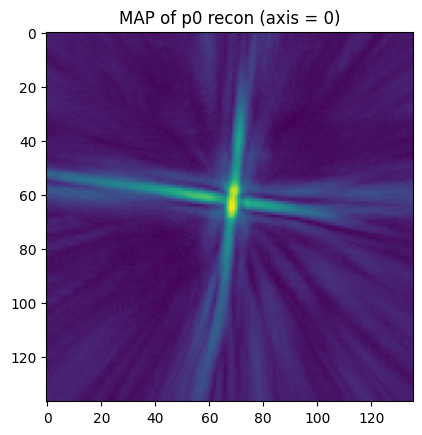

In [26]:
MAP_AXIS = 0;
map_img = tf.math.reduce_max(p0_recon, axis=MAP_AXIS)
plt.imshow(map_img)
plt.title(f"MAP of p0 recon (axis = {MAP_AXIS})")
plt.show()

In [27]:
indices = np.zeros([sparse_mat_dict["Cols"].shape[-1], 2], dtype=np.int64)
indices[:, 1] = np.array(sparse_mat_dict["Cols"], dtype=np.int64) - 1
indices[:, 0] = np.array(sparse_mat_dict["Rows"], dtype=np.int64) - 1
values = np.array(sparse_mat_dict["data"], dtype=np.float16).flatten()
dense_shape = np.array(sparse_mat_dict["arr_size"]).flatten()

In [28]:
dense_shape

array([2496688., 1966080.])

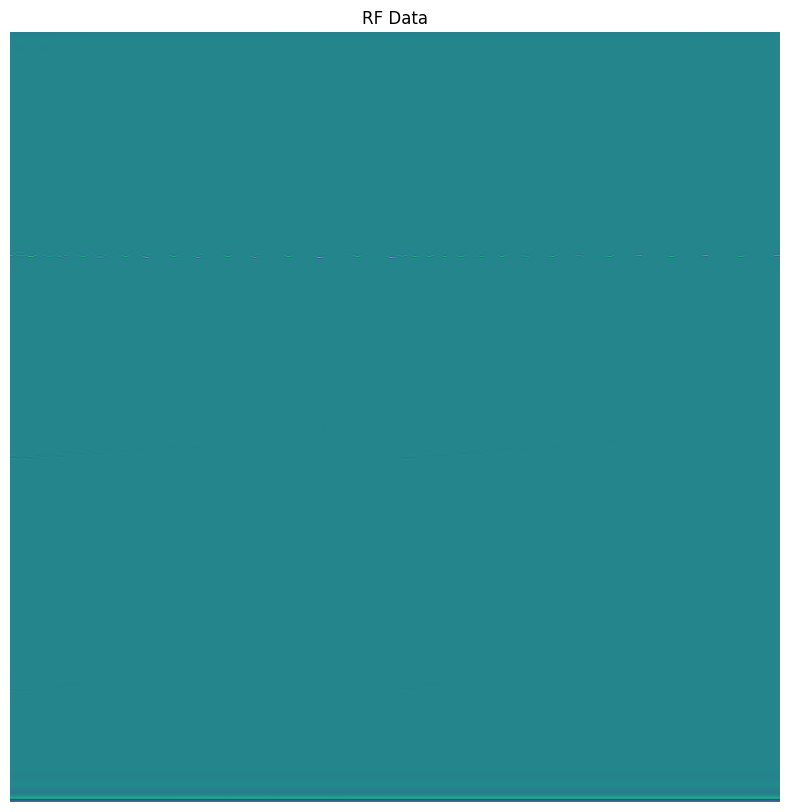

In [29]:
norm_rfdata = (rfdata - np.min(rfdata))/(np.max(rfdata) - np.min(rfdata))
plt.figure(figsize=(10, 10))
plt.imshow(rfdata, extent=[0, 1, 0, 1])
plt.axis('off')
plt.title("RF Data")
plt.show()

In [30]:
rfdata_flat = rfdata.T.flatten()[..., tf.newaxis]
print(rfdata_flat.shape)

(1966080, 1)


In [31]:
M = tf.sparse.SparseTensor(indices, values, dense_shape)

In [34]:
rfdata_flat = tf.cast(rfdata_flat, dtype=tf.float16)

In [35]:
@tf.function
def tf_gpu_matmul(M, x):
    return tf.sparse.sparse_dense_matmul(M, x)

In [37]:
%timeit out = tf_gpu_matmul(M, rfdata_flat)

27.7 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as csr_gpu
from scipy.sparse import csr_array

indices = np.zeros([sparse_mat_dict["Cols"].shape[-1], 2], dtype=np.uint32)
indices[:, 0] = np.array(sparse_mat_dict["Cols"], dtype=np.uint32) - 1
indices[:, 1] = np.array(sparse_mat_dict["Rows"], dtype=np.uint32) - 1
values = np.array(sparse_mat_dict["data"], dtype=np.float16).flatten()
dense_shape = np.array(sparse_mat_dict["arr_size"], dtype=np.uint32).flatten()

In [9]:
# def gpu_matmul(M, x, gpu_id=GPU):
#     with cp.cuda.Device(gpu_id):
#         M_gpu = csr_gpu(M)  #moving A to the gpu
#         x_gpu = cp.array(x) #moving x to the gpu

#         x_gpu = M_gpu.dot(x_gpu)
#     out = cp.asnumpy(x_gpu) #back to numpy object for fast indexing
#     return out

def gpu_matmul(M_gpu, x_gpu):
    x_gpu = M_gpu.dot(x_gpu)
    return x_gpu

In [10]:
rfdata_flat = rfdata.T.flatten()[..., tf.newaxis]
print(rfdata_flat.shape)

(1966080, 1)


In [11]:
M = csr_array((values, (indices[:, 1], indices[:, 0])), shape=dense_shape) #(scipy.sparse.csr_matrix)
x = np.array(rfdata_flat, dtype=np.float16)  #(numpy.ndarray)

In [13]:
out = gpu_matmul(M, x)
p0_recon = tf.reshape(out, (134, 137, 136))
p0_recon = np.array(p0_recon, dtype=np.float32)

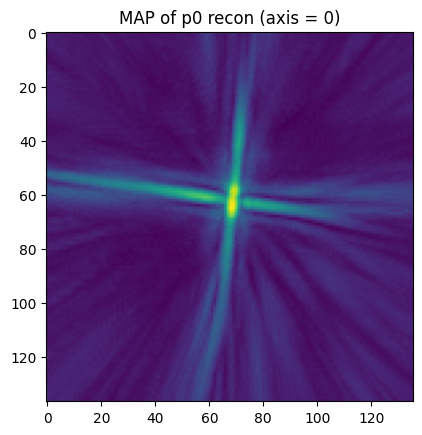

In [14]:
MAP_AXIS = 0;
map_img = tf.math.reduce_max(p0_recon, axis=MAP_AXIS)
plt.imshow(map_img)
plt.title(f"MAP of p0 recon (axis = {MAP_AXIS})")
plt.show()

## Timing Analysis

In [13]:
import cupy
from cupyx.profiler import benchmark
mempool = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()
# You can access statistics of these memory pools.
print(mempool.used_bytes())              # 0
print(mempool.total_bytes())             # 0
print(pinned_mempool.n_free_blocks())    # 0

0
0
0


In [14]:
with cp.cuda.Device(GPU):
    M_gpu = csr_gpu(M)  #moving A to the gpu
    # You can access statistics of these memory pools.
    print(mempool.used_bytes())
    print(mempool.total_bytes())
    print(pinned_mempool.n_free_blocks())
    print('\n')
    x_gpu = cp.array(x) #moving x to the gpu
    print(mempool.used_bytes())
    print(mempool.total_bytes())
    print(pinned_mempool.n_free_blocks())
    print('\n')
    print(benchmark(gpu_matmul, kwargs={'M_gpu': M_gpu, 'x_gpu': x_gpu},
                    n_repeat=50, n_warmup=10))

5123204096
5123204096
1


5127136256
5127136256
1


gpu_matmul          :    CPU:   176.510 us   +/- 61.806 (min:   136.980 / max:   410.660) us     GPU-1:  7450.564 us   +/- 55.405 (min:  7406.464 / max:  7659.520) us


In [15]:
5123204096/1e9

5.123204096

In [16]:
5127136256/1e9

5.127136256

In [ ]:
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

In [18]:
indices.shape

(639152128, 2)

In [19]:
values.shape

(639152128,)

In [22]:
((1/3*1/4)+2/3)

0.8333333333333333